## Answering Business Questions using SQL


In the previous mission we learned how to use python's SQLite module. We can also use pandas to write queries that produced dataframe outputs. The advantage of dataframe outputs is that they will display as tables in Jupyter notebook. We can also take advantage of pandas plotting methods to easily create visualizations of our tables inside our Jupyter notebook.

We can use the `sqlite3.connect()` function to create a connection object, and pass that to the `pandas.read_sql_query() function`. In this project, we'll use this approach. In addition, we'll:

* Create some helper functions in python to save some time.
* Use a **context manager** to handle the connection to the SQLite database.

## Mission

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

Artist Name	Genre
Regal	Hip-Hop
Red Tone	Punk
Meteor and the Girls	Pop
Slim Jim Bites	Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

db = './dataset/chinook.db'

**Context managers** take care of:
* opening & closing connection to the database
* making sure we don't accidentally make changes to the database if one of our queries as an error

Use the `with` statement to access the context manager that's built-in to the SQLite module. 

Below turned the code into a function. By returning a dataframe we can just run our function as the last line of a Jupyter cell & will print the results nicely for us. 

In [2]:
# a function that takes SQL query as an argument & returns pd dataframe of that query.
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

# running SQL queries that don't return tables    
# a function that takes SQL command as argument & executes it using sqlite module
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

# return a list of tables & views in our database
# function that calls run_query() to returns a lists of all tables and views in the database
def show_tables():
    q = '''
    SELECT 
        name,
        type
    FROM sqlite_master
    WHERE type IN ('table', 'view')
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

Write a query that returns each genre, with the number of tracks sold in the USA:
* in absolute numbers
* in percentages.

In [3]:
q = '''
     SELECT * FROM invoice_line 
     LIMIT 5
     '''

run_query(q)

,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,1,1,1158,0.99,1
1,2,1,1159,0.99,1
2,3,1,1160,0.99,1
3,4,1,1161,0.99,1
4,5,1,1162,0.99,1


In [4]:
## 1. Joining customer info (to get country) to invoice_line info (info on each purchase)
## via invoice table
## 2. Joining the usa purchase info to genre info to group usa purchases by genre

albums_to_purchase = '''
WITH usa_tracks_sold AS
    (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = 'USA'
    )
    
SELECT 
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    ROUND(CAST(COUNT(uts.invoice_line_id) AS FLOAT) /
        (
        SELECT COUNT(*) FROM usa_tracks_sold
        ) * 100, 1) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY genre
ORDER BY tracks_sold DESC
LIMIT 10
'''


run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,53.4
1,Alternative & Punk,130,12.4
2,Metal,124,11.8
3,R&B/Soul,53,5.0
4,Blues,36,3.4
5,Alternative,35,3.3
6,Pop,22,2.1
7,Latin,22,2.1
8,Hip Hop/Rap,20,1.9
9,Jazz,14,1.3


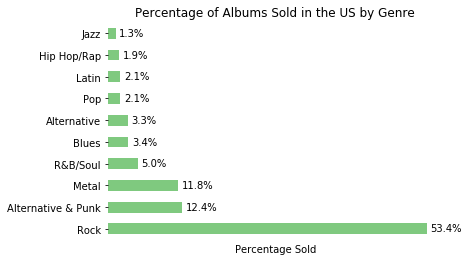

In [5]:
genre_sales_usa = run_query(albums_to_purchase)

ax = genre_sales_usa.plot(x='genre', y='percentage_sold', kind='barh', colormap= plt.cm.Accent)

plt.ylabel('') 
plt.xlabel('Percentage Sold')
plt.title('Percentage of Albums Sold in the US by Genre')

for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.6
        y = p.get_y() + p.get_height()/4
        ax.annotate(percentage, (x, y))

for key, spine in ax.spines.items():
    spine.set_visible(False)

ax.tick_params(bottom=False, labelbottom=False)
ax.legend().set_visible(False)

plt.show()

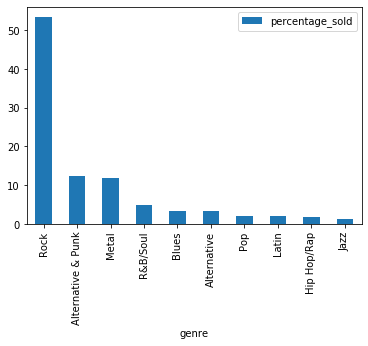

In [6]:
genre_sales_usa = run_query(albums_to_purchase)


genre_sales_usa.plot.bar(x='genre', y='percentage_sold')


Write a paragraph that interprets the data and makes a recommendation for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.

The top selling genre in the USA is Rock, with more than 50% of all the tracks bought on Chinook from the Rock genre. This is followed by Alternative & Punk and close third is Metal at 11.8%. 

Based on this analysis my recommendation would be that from the list of four albums to choose from, based on their genre I would choose Red Tone (Punk), Meteor & the Girls (Pop) and Slim Jim Bites (Blues). I wouldn't select Regal (Hip-Hop) as it's the lowest ranking genre (least purchases from the USA) of the four. 

## Analysing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [7]:

employee_sales_performance = '''

WITH customer_support_rep_sales AS
    (
    SELECT 
        i.customer_id,
        c.support_rep_id,
        SUM(i.total) total_purchased
    FROM invoice i
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY 1, 2
    )

SELECT 
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total_purchased) total_sales    
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1
ORDER BY 3 DESC
'''


run_query(employee_sales_performance)


,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


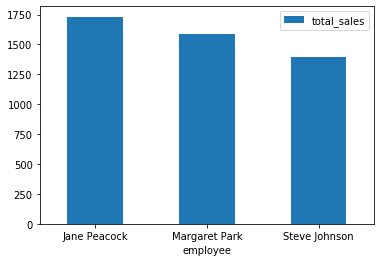

In [8]:
employee_sales = run_query(employee_sales_performance)

employee_sales.plot.bar(x='employee', y='total_sales', rot=0)

There is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee). 
The difference roughly corresponds with the differences in their hiring dates. 

## Analysing Sales by Country

Analysing the sales data for customers from each different country. 

You have been given guidance to use the country value from the `customer` table, and ignore the country from the billing address in the `invoice` table.

In particular, you have been directed to calculate data, for each country, on the:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Where a country has only one customer, collect them into an "Other" group.
The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.

NOTE about solution:
`WHERE country=c.country` is an example of removing a correlated subquery. More info here: https://community.dataquest.io/t/case-and-subqueries/4285/3
Need to come back to this as not entirely clear. 

In [9]:

sales_by_country = '''
WITH country_or_other AS
    (
    SELECT 
        CASE 
            WHEN (
                  SELECT count(*)
                  FROM customer
                  WHERE country = c.country
                ) = 1 THEN 'Other'
            ELSE c.country
        END AS country,
        c.customer_id,
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    )


SELECT 
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = 'Other' THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''


run_query(sales_by_country)



,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


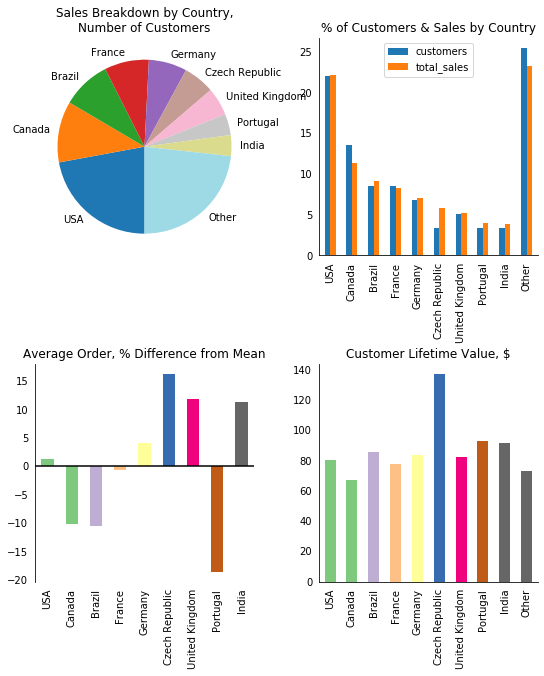

In [10]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)

# Assigning a specific colour to a country for easy comparison between graphs
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))

# With axes.flatten() you get a 1-dimension array with all the axes 
# and you can iterate over them without the need of unpacking them and doing it manually.
ax1, ax2, ax3, ax4 = axs.flatten()

# To create spaces between the multiple axes & avoid overlapping
fig.subplots_adjust(hspace=.5, wspace=.3)

#top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.tab20,
#     wedgeprops={'linewidth':0}
)

#top right
cvd_cols = ['customers','total_sales']
custs_vs_dollars = country_metrics[cvd_cols].copy()

custs_vs_dollars.index.name = ''
# custs_vs_dollars['customers'] = custs_vs_dollars['customers']/custs_vs_dollars['customers'].sum() * 100
# custs_vs_dollars['total_sales'] = custs_vs_dollars['total_sales']/custs_vs_dollars['total_sales'].sum() * 100
# Can shorten the above using a for loop:    
for c in cvd_cols:
    custs_vs_dollars[c] = custs_vs_dollars[c]/custs_vs_dollars[c].sum() * 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    title = '% of Customers & Sales by Country',
)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(top=False, right=False, left=False, bottom=False)

#bottom left
avg_order = country_metrics['average_order'].copy()
# NOt sure what the point of the below command is which was in the solutions code
# avg_order.index.name = ''
difference_from_avg = (avg_order - avg_order.mean())/avg_order.mean() * 100
difference_from_avg.drop('Other', inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title = 'Average Order, % Difference from Mean'
)

ax3.tick_params(top=False, right=False, left=False, bottom=False)
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
ax3.set_xlabel('')

#bottom right
cust_life_val = country_metrics['customer_lifetime_value'].copy()
cust_life_val.plot.bar(
    ax=ax4,
    color=colors,
    title = 'Customer Lifetime Value, $'
)
ax4.tick_params(top=False, right=False, left=False, bottom=False)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.set_xlabel('')


plt.show()



From the above charts it appears that countries with potential for growth are:
* Czech Republic
* UK
* India

NOTE: sample size (amount of data from each country) is not large enough to give us high confidence. So need to be cautious about spending too much money on new marketing campaigns. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.


## Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.


Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
* Number of invoices
* Percentage of invoices

In [11]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     /* 1.Take any track, here used MIN but can also use MAX */
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    /* 8.Count number of invoices that were full album purchase or not */
    COUNT(invoice_id) number_of_invoices,
    /* 9. Number of invoices, grouped by album_purchase, divide by total invoices */
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  /* 3.Select all the tracks only where album is the below  */
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = 
                                      /* 2.Select album only where track matches the invoice track (1.)
                                      i.e. identifying the album that the invoice track is assoc with */
                                    (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 
                  /* 4.Are all the above tracks in the album also in the invoice line? */
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 /* 5.And vice versa, all tracks in invoice also in album? */
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             /* 6.If both null then both have everything same i.e. True/Yes
             otherwise False/No */
             THEN "yes"
             ELSE "no"
         /* 7.Create album_purchase column with the values */
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

## Next steps...

* Which artist is used in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs non-protected media types have an effect on popularity?

## Most popular artist based on playlists

Which artist is used in most playlists

In [12]:
popular_artists = '''
WITH artists_associated_playlist AS
    (
     SELECT
         p.name playlist_name,
         ar.name artist
     FROM playlist p
     INNER JOIN playlist_track pt ON pt.playlist_id = p.playlist_id
     INNER JOIN track t ON t.track_id = pt.track_id
     INNER JOIN album al ON al.album_id = t.album_id
     INNER JOIN artist ar ON ar.artist_id = al.artist_id
     )

SELECT 
    artist,
    COUNT(playlist_name) number_of_playlists,
    ROUND(CAST(COUNT(playlist_name) AS FLOAT) / (
                            SELECT COUNT(*) 
                            FROM artists_associated_playlist
                            )*100, 1) percent
FROM artists_associated_playlist
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5
'''

run_query(popular_artists)
         

,artist,number_of_playlists,percent
0,Iron Maiden,516,5.9
1,U2,333,3.8
2,Metallica,296,3.4
3,Led Zeppelin,252,2.9
4,Deep Purple,226,2.6


Iron Maiden is used in most playlists. 

The band appears in a total of 516 playlists, accounting for 5.9% of all the playlists. 

## Purchased vs not purchased tracks

How many tracks have been purchased vs not purchased?

In [24]:
purchase_vs_not_purchased = '''
SELECT 
    CASE
        WHEN il.track_id IS NULL THEN 'No'
        ELSE 'Yes'
        END
        AS track_purchased,
    COUNT(DISTINCT t.track_id) num_of_tracks,
    ROUND(CAST(COUNT(DISTINCT t.track_id) AS FLOAT) / (
                                        SELECT COUNT(track_id) FROM track
                                       )*100,1) percentage
FROM track t
LEFT JOIN invoice_line il ON il.track_id = t.track_id
GROUP BY track_purchased
'''  
    
run_query(purchase_vs_not_purchased)

,track_purchased,num_of_tracks,percentage
0,No,1697,48.4
1,Yes,1806,51.6


Just over half (52%) of the tracks in the Chinook record store have been purhchased. 

## Protected vs non-protected tracks

Do protected vs non-protected media types have an effect on popularity?

In [31]:
q = '''
SELECT * FROM media_type
GROUP BY media_type_id;
'''

run_query(q)

,media_type_id,name
0,1,MPEG audio file
1,2,Protected AAC audio file
2,3,Protected MPEG-4 video file
3,4,Purchased AAC audio file
4,5,AAC audio file


In [35]:
protected_vs_not_protected = '''
SELECT
    CASE
        WHEN mt.media_type_id == 2 OR mt.media_type_id == 3 THEN "Yes"
        ELSE "No"
        END
        AS protected,
    COUNT(il.invoice_line_id) number,
    ROUND(CAST(COUNT(il.invoice_id) AS FLOAT) /
                                      (
                                      SELECT COUNT(invoice_id)
                                      FROM invoice_line
                                      )*100, 1) percentage
FROM media_type mt
INNER JOIN track t ON t.media_type_id = mt.media_type_id
INNER JOIN invoice_line il ON il.invoice_line_id = t.track_id
GROUP BY protected;
'''

run_query(protected_vs_not_protected)

,protected,number,percentage
0,No,3052,64.2
1,Yes,451,9.5


Based on above protected media types don't appear to have an effect on popularity since most purchased tracks were not protected.

Based on further investigation you can see below that more protected AAC audio files are purchased (237) than unprotected AAC audio files (11). However, the most purchased tracks are MPEG audio files. THe only protected MPEG files are video files which are even less popular/purchased than protected AAC audio files. 

Should see if it's possible to create and sell protected MPEG audio files. 

In [36]:
tracks_media_type = '''
SELECT
    mt.name,
    COUNT(il.invoice_line_id)
FROM media_type mt
INNER JOIN track t ON t.media_type_id = mt.media_type_id
INNER JOIN invoice_line il ON il.invoice_line_id = t.track_id
GROUP BY mt.name;
'''

run_query(tracks_media_type)

,name,COUNT(il.invoice_line_id)
0,AAC audio file,11
1,MPEG audio file,3034
2,Protected AAC audio file,237
3,Protected MPEG-4 video file,214
4,Purchased AAC audio file,7
